# Tacking Point Estimation

In [213]:
import jax.numpy as jnp
from jax import Array
from jax import vmap, jit

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr
import matplotlib.cm as cm

import pickle

import os

from abc import ABC

from load_manifold import load_manifold

from geometry.manifolds import LorentzFinslerManifold, nEllipsoid, nSphere, T2, RiemannianNavigation, nEuclidean
from geometry.tacking import SequentialOptimizationBFGS, SequentialOptimizationADAM, GEORCE_HTacking
from geometry.geodesic import GEORCE_H, GEORCE_HStep

In [214]:
figure_path = '../figures/tacking_estimation/'

In [215]:
plt.rcParams.update({'font.size': 25})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

In [216]:
if not (os.path.exists(figure_path)):
    os.makedirs(figure_path)

In [217]:
data_path = 'tacking_gpu/deterministic/'
T = 1_000

## Direction-Only Dependent Finsler Metrics

In [6]:
save_path = ''.join((data_path, 'direction_only/'))
    
onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]

In [7]:
file_path = ''.join((save_path, onlyfiles[0]))
with open(file_path, 'rb') as f:
    curves = pickle.load(f)

/tmp/ipykernel_535094/2103964614.py:3: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  curves = pickle.load(f)


In [8]:
for k,v in curves.items():
    print(f"Geodesic {k}: \t\t\t -Travel time = {v['travel_time']:.4f}")

Geodesic Geodesic: 			 -Travel time = 11.0236
Geodesic ReverseGeodesic: 			 -Travel time = 9.5014
Geodesic Tacking_1: 			 -Travel time = 6.9297
Geodesic ReverseTacking_1: 			 -Travel time = 6.9297
Geodesic Tacking_2: 			 -Travel time = 6.9287
Geodesic ReverseTacking_2: 			 -Travel time = 6.9287
Geodesic Tacking_3: 			 -Travel time = 6.9287
Geodesic ReverseTacking_3: 			 -Travel time = 6.9287
Geodesic Tacking_4: 			 -Travel time = 6.9287
Geodesic ReverseTacking_4: 			 -Travel time = 6.9287


In [9]:
t0, z0, zT, tack_metrics, reverse_tack_metrics = load_manifold("direction_only")

In [10]:
xscales = [-4.0, 5.0]
yscales = [-1.0, 9.0]

In [11]:
n_points = 3
x1 = jnp.linspace(xscales[0], xscales[1], n_points)
x2 = jnp.linspace(yscales[0], yscales[1], n_points)

X1, X2 = jnp.meshgrid(x1,x2)

In [12]:
indicatrix_alpha = vmap(vmap(lambda u,v: jnp.stack((u,v))+tack_metrics[0].indicatrix(0.0, jnp.stack((u,v)), N_points=100)))(X1,X2)#, grid=jnp.linspace(-5,5,1000), eps=1e-6)
indicatrix_beta = vmap(vmap(lambda u,v: jnp.stack((u,v))+reverse_tack_metrics[0].indicatrix(0.0, jnp.stack((u,v)), N_points=100)))(X1,X2)#, grid=jnp.linspace(-5,5,1000), eps=1e-6)

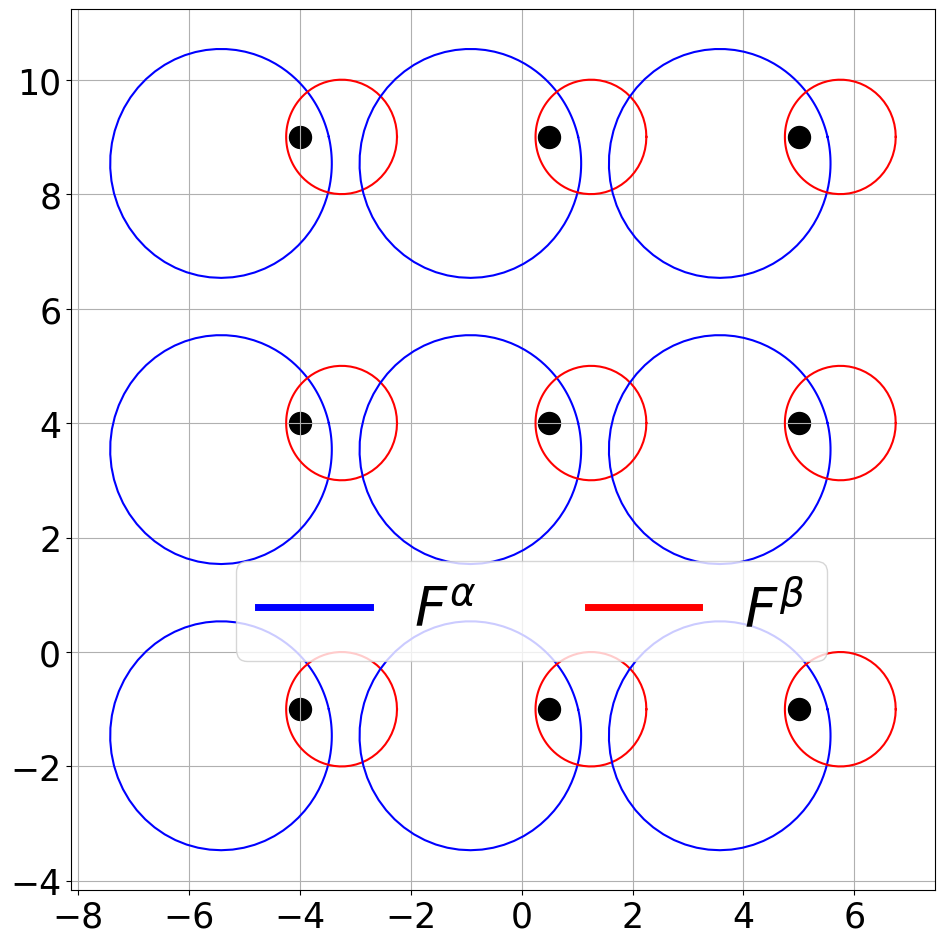

In [13]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

for i1, i2,x1,x2 in zip(indicatrix_alpha, indicatrix_beta, X1, X2):
    for b1, b2, y1, y2 in zip(i1, i2, x1, x2):
        ax.plot(b1[:,0], b1[:,1], color='blue')
        ax.plot(b2[:,0], b2[:,1], color='red')
        ax.scatter(y1, y2, s=250, color='black')

ax.grid(True)

ax.plot([0],[0], color="blue", label=r'$F^{\alpha}$', linewidth=5.0)
ax.plot([0],[0], color="red", label=r'$F^{\beta}$', linewidth=5.0)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.25,0.30), ncol=2, fontsize=40)
    
fig.tight_layout()

save_path = f'{figure_path}direction_only_indicatrix.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

fig.tight_layout()

plt.show()

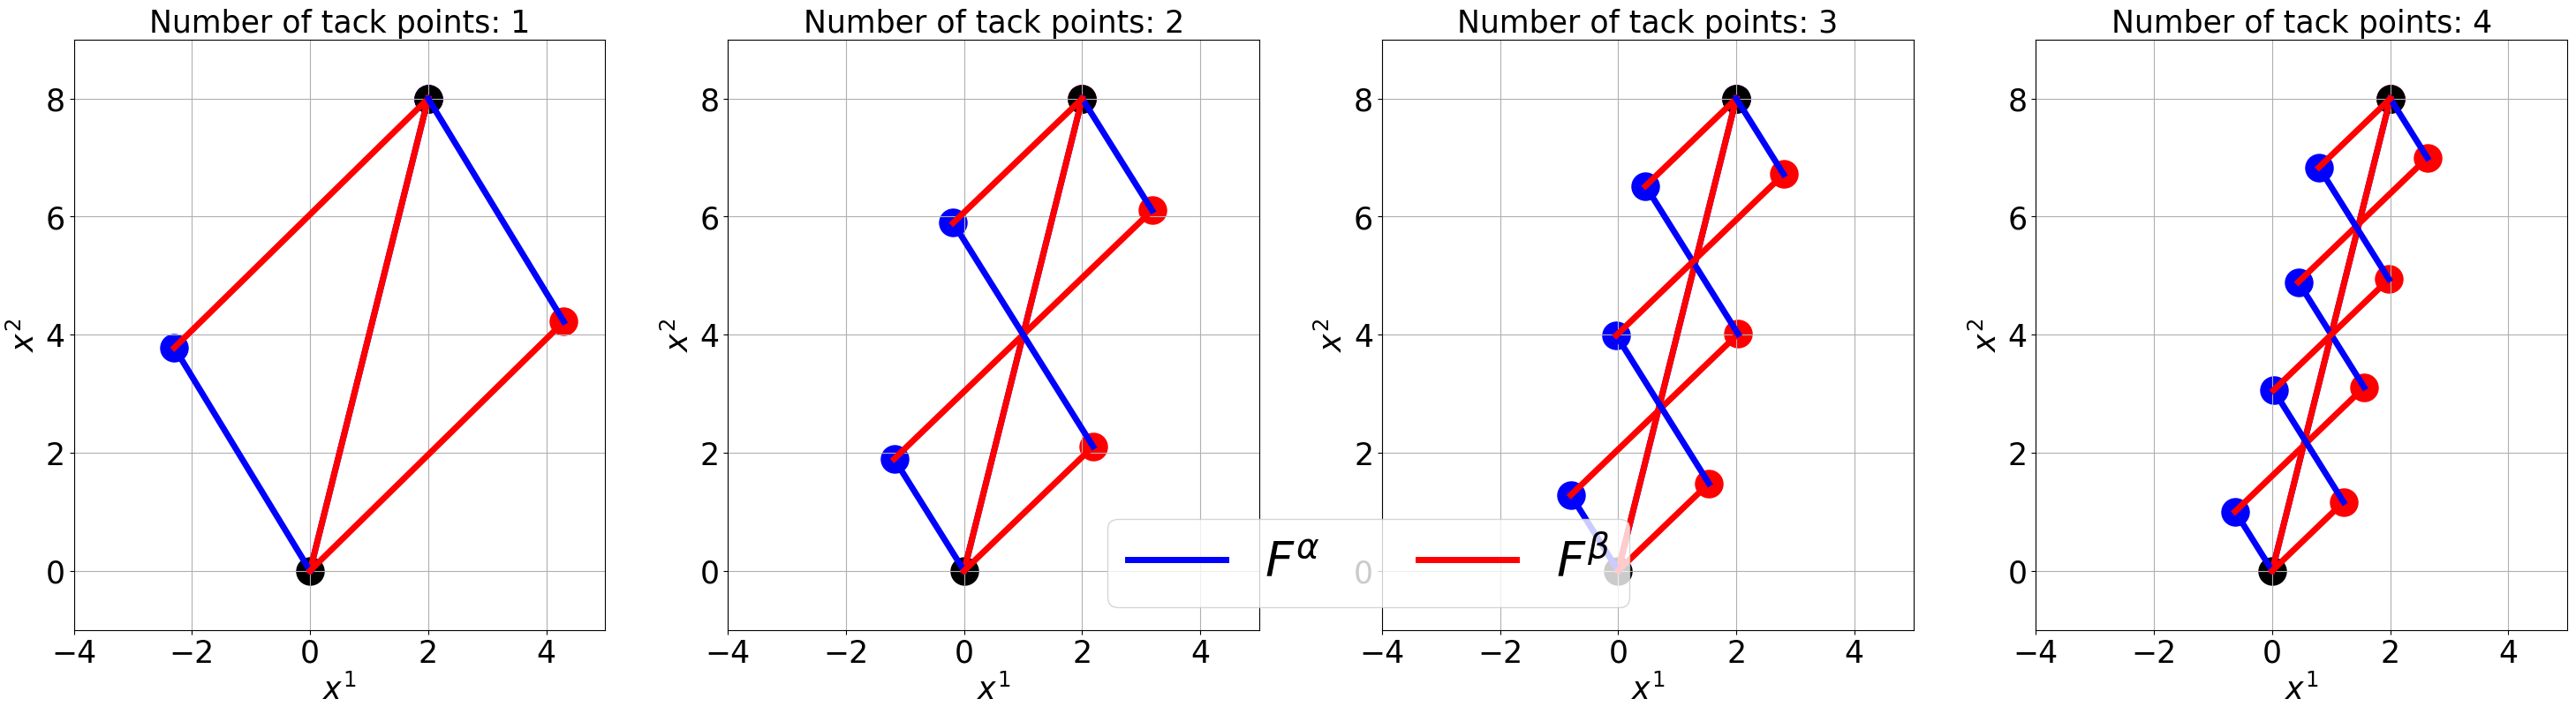

In [14]:
N_tacks = len(curves.keys())//2-1

fig = plt.figure(figsize=((N_tacks-1)*10,10))

for i in range(1, N_tacks+1):
    ax = fig.add_subplot(1,N_tacks,i)
    
    #Curves with no tacking
    ax.plot(curves['Geodesic']['zs'][:,0], curves['Geodesic']['zs'][:,1], color='blue', linewidth=5.0, alpha=1.0)
    ax.plot(curves['ReverseGeodesic']['zs'][:,0], curves['ReverseGeodesic']['zs'][:,1], color='red', linewidth=5.0, alpha=1.0)
    
    tack_curve = curves[f'Tacking_{i}']['zs']
    reverse_tack_curve = curves[f'ReverseTacking_{i}']['zs']
    
    #Plotting curves
    for j in range(i+1):
        if j % 2 == 0:
            #Plotting Curves
            ax.plot(tack_curve[(T*j):(T*(j+1))][:,0], 
                    tack_curve[(T*j):(T*(j+1))][:,1], 
                    color="blue",
                    linewidth=5.0)
            ax.plot(reverse_tack_curve[(T*j):(T*(j+1))][:,0], 
                    reverse_tack_curve[(T*j):(T*(j+1))][:,1], 
                    color="red",
                    linewidth=5.0)
            
            #Plotting points
            ax.scatter(tack_curve[(T*(j+1))][0], 
                       tack_curve[(T*(j+1))][1],
                       color="blue",
                       s=500)
            ax.scatter(reverse_tack_curve[(T*(j+1))][0], 
                       reverse_tack_curve[(T*(j+1))][1],
                       color="red",
                       s=500)
        else:
            #Plotting Curves
            ax.plot(tack_curve[(T*j):(T*(j+1))][:,0], 
                    tack_curve[(T*j):(T*(j+1))][:,1], 
                    color="red",
                    linewidth=5.0)
            ax.plot(reverse_tack_curve[(T*j):(T*(j+1))][:,0], 
                    reverse_tack_curve[(T*j):(T*(j+1))][:,1], 
                    color="blue",
                    linewidth=5.0)
            
            #Plotting points
            ax.scatter(tack_curve[(T*(j+1))][0], 
                       tack_curve[(T*(j+1))][1],
                       color="red",
                       s=500)
            ax.scatter(reverse_tack_curve[(T*(j+1))][0], 
                       reverse_tack_curve[(T*(j+1))][1],
                       color="blue",
                       s=500)

    ax.set_xlabel(r'$x^{1}$', fontsize=25)
    ax.set_ylabel(r'$x^{2}$', fontsize=25)
    ax.set_title(f"Number of tack points: {i}", fontsize=25)
    ax.grid(True)
    ax.set_xlim(xscales[0], xscales[1])
    ax.set_ylim(yscales[0], yscales[1])
    ax.set_aspect('equal', adjustable='box')
    
    #Start and end point
    ax.scatter(z0[0], z0[1], color="black", s=500)
    ax.scatter(zT[0], zT[1], color="black", s=500)

ax.plot([0],[0], color="blue", label=r'$F^{\alpha}$', linewidth=5.0)
ax.plot([0],[0], color="red", label=r'$F^{\beta}$', linewidth=5.0)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.43,0.15), ncol=2, fontsize=40)
    
fig.tight_layout()

save_path = f'{figure_path}direction_only.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')
    
plt.show()


## Time-Only Dependent Finsler Metrics

In [15]:
save_path = ''.join((data_path, 'time_only/'))
    
onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]

In [16]:
file_path = ''.join((save_path, onlyfiles[0]))
with open(file_path, 'rb') as f:
    curves = pickle.load(f)

/tmp/ipykernel_535094/2103964614.py:3: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  curves = pickle.load(f)


In [17]:
for k,v in curves.items():
    print(f"Geodesic {k}: \t\t\t -Travel time = {v['travel_time']:.4f}")

Geodesic Geodesic: 			 -Travel time = 8.0441
Geodesic ReverseGeodesic: 			 -Travel time = 7.0638
Geodesic Tacking_1: 			 -Travel time = 7.1324
Geodesic ReverseTacking_1: 			 -Travel time = 6.2762


In [18]:
t0, z0, zT, tack_metrics, reverse_tack_metrics = load_manifold("time_only")

In [19]:
n_points = 3
n_times = 4
t_grid = jnp.linspace(0.0,10.0,n_times)
x1 = jnp.linspace(-1.0, 12.0, n_points)
x2 = jnp.linspace(-1.0, 6.0, n_points)

X1, X2 = jnp.meshgrid(x1,x2)

In [20]:
indicatrix_alpha = vmap(lambda t: vmap(vmap(lambda u,v: jnp.stack((u,v))+tack_metrics[0].indicatrix(t, jnp.stack((u,v)), N_points=100)))(X1,X2))(t_grid)#, grid=jnp.linspace(-5,5,1000), eps=1e-6)
indicatrix_beta = vmap(lambda t: vmap(vmap(lambda u,v: jnp.stack((u,v))+reverse_tack_metrics[0].indicatrix(t, jnp.stack((u,v)), N_points=100)))(X1,X2))(t_grid)#, grid=jnp.linspace(-5,5,1000), eps=1e-6)

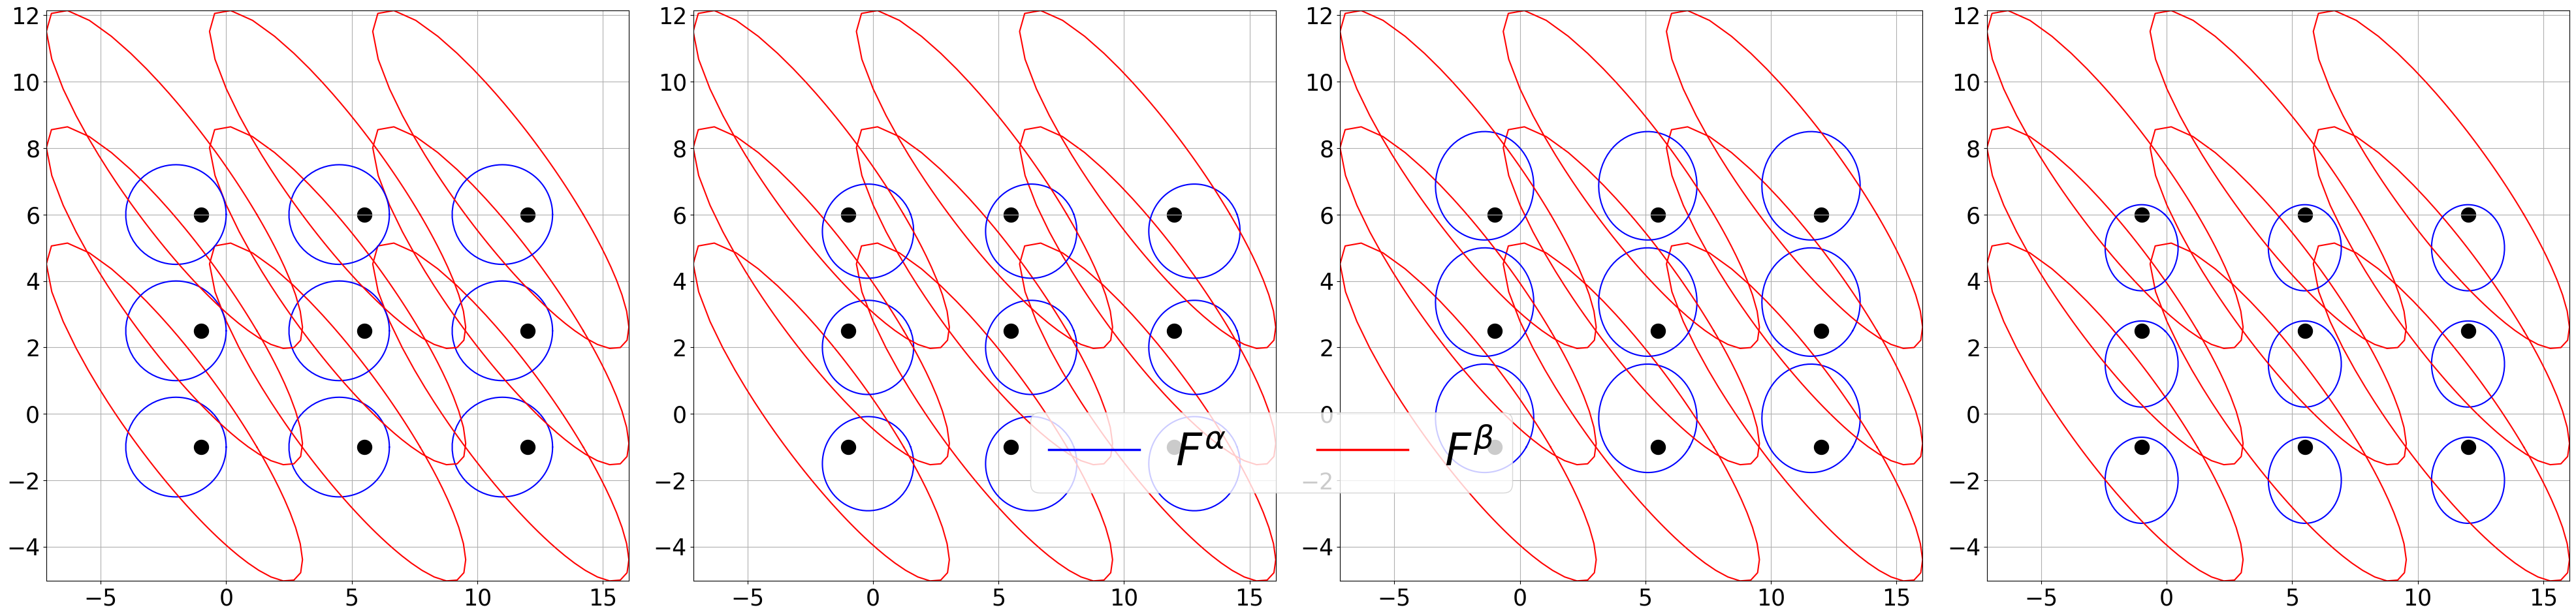

In [21]:
fig = plt.figure(figsize=(len(indicatrix_alpha)*10,10))

for i in range(len(indicatrix_alpha)):
    ax = fig.add_subplot(1, n_times, i+1)
    for i1, i2,x1,x2 in zip(indicatrix_alpha[i], indicatrix_beta[i], X1, X2):
        for b1, b2, y1, y2 in zip(i1, i2, x1, x2):
            ax.plot(b1[:,0], b1[:,1], color='blue')
            ax.plot(b2[:,0], b2[:,1], color='red')
            ax.scatter(y1, y2, s=250, color='black')
        ax.set_xlim(jnp.min(jnp.array([jnp.min(indicatrix_beta[:,:,:,:,0]),
                                       jnp.min(indicatrix_alpha[:,:,:,:,0])
                                      ])),
                    jnp.max(jnp.array([jnp.max(indicatrix_beta[:,:,:,:,0]),
                                       jnp.max(indicatrix_alpha[:,:,:,:,0])
                                      ]))
                   )
        ax.set_ylim(jnp.min(jnp.array([jnp.min(indicatrix_beta[:,:,:,:,1]),
                                       jnp.min(indicatrix_alpha[:,:,:,:,1])
                                      ])),
                    jnp.max(jnp.array([jnp.max(indicatrix_beta[:,:,:,:,1]),
                                       jnp.max(indicatrix_alpha[:,:,:,:,1])
                                      ]))
                   )
        ax.grid(True)

ax.plot([0],[0], color="blue", label=r'$F^{\alpha}$', linewidth=2.5)
ax.plot([0],[0], color="red", label=r'$F^{\beta}$', linewidth=2.5)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.4,0.2), ncol=2, fontsize=50)

fig.tight_layout()

save_path = f'{figure_path}time_only_indicatrix.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()

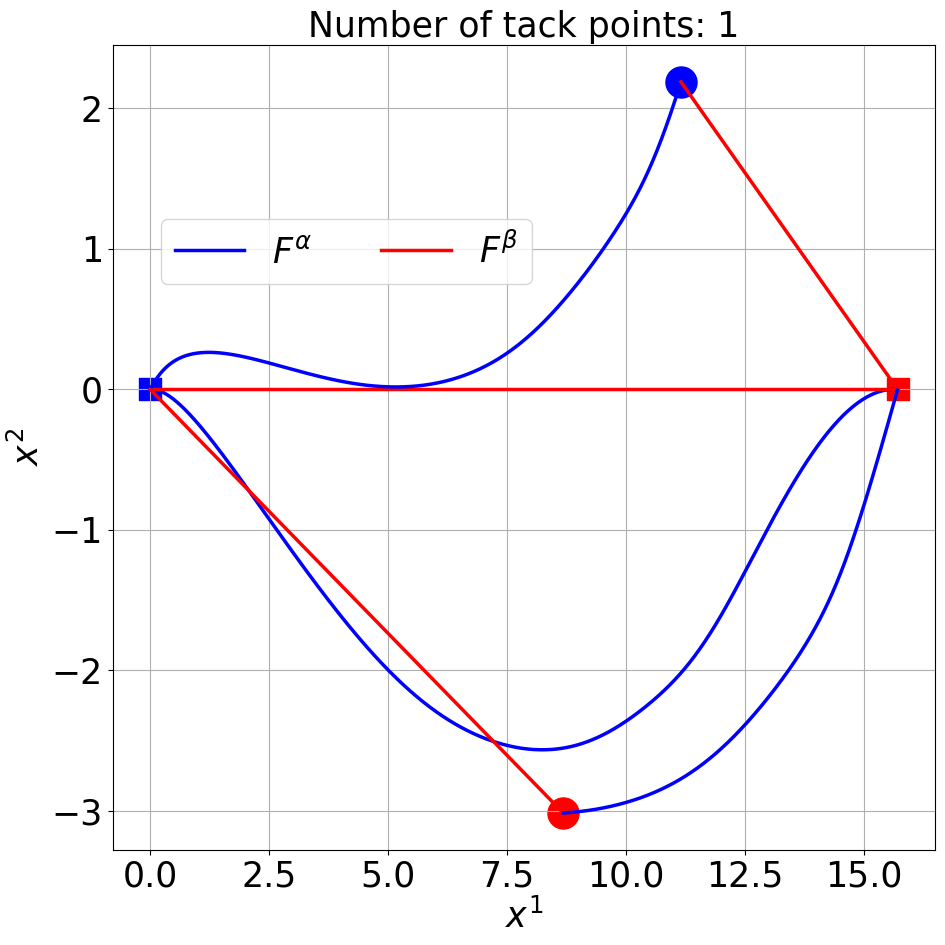

In [22]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

#Curves with no tacking
ax.plot(curves['Geodesic']['zs'][:,0], curves['Geodesic']['zs'][:,1], color='blue', linewidth=2.5, alpha=1.0)
ax.plot(curves['ReverseGeodesic']['zs'][:,0], curves['ReverseGeodesic']['zs'][:,1], color='red', linewidth=2.5, alpha=1.0)

#Plotting tack curves
for j in range(2):
    
    tack_curve = curves['Tacking_1']['zs']
    reverse_tack_curve = curves['ReverseTacking_1']['zs']
    
    if j % 2 == 0:
        #Plotting Curves
        ax.plot(tack_curve[(T*j):(T*(j+1))][:,0], 
                tack_curve[(T*j):(T*(j+1))][:,1], 
                color="blue",
                linewidth=2.5)
        ax.plot(reverse_tack_curve[(T*j):(T*(j+1))][:,0], 
                reverse_tack_curve[(T*j):(T*(j+1))][:,1], 
                color="red",
                linewidth=2.5)

        #Plotting points
        ax.scatter(tack_curve[(T*(j+1))][0], 
                   tack_curve[(T*(j+1))][1],
                   color="blue",
                   s=500)
        ax.scatter(reverse_tack_curve[(T*(j+1))][0], 
                   reverse_tack_curve[(T*(j+1))][1],
                   color="red",
                   s=500)
    else:
        #Plotting Curves
        ax.plot(tack_curve[(T*j):(T*(j+1))][:,0], 
                tack_curve[(T*j):(T*(j+1))][:,1], 
                color="red",
                linewidth=2.5)
        ax.plot(reverse_tack_curve[(T*j):(T*(j+1))][:,0], 
                reverse_tack_curve[(T*j):(T*(j+1))][:,1], 
                color="blue",
                linewidth=2.5)

ax.set_xlabel(r'$x^{1}$', fontsize=25)
ax.set_ylabel(r'$x^{2}$', fontsize=25)
ax.set_title("Number of tack points: 1", fontsize=25)
ax.grid(True)
#ax.set_xlim(xscales[0], xscales[1])
#ax.set_ylim(yscales[0], yscales[1])
#ax.set_aspect('equal', adjustable='box')

ax.plot([0],[0], color="blue", label=r'$F^{\alpha}$', linewidth=2.5)
ax.plot([0],[0], color="red", label=r'$F^{\beta}$', linewidth=2.5)

#Start and end point
ax.scatter(z0[0], z0[1], marker="s", color="blue", s=250)
ax.scatter(zT[0], zT[1], marker="s", color="red", s=250)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.17,0.7), ncol=2, fontsize=25)
    
fig.tight_layout()

save_path = f'{figure_path}time_only.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')
    
plt.show()

## Poincarre

In [218]:
model_name = 'poincarre' #poincarre, poincarre_north

In [219]:
save_path = ''.join((data_path, f'{model_name}/'))
    
onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]

In [220]:
file_path = ''.join((save_path, onlyfiles[0]))
with open(file_path, 'rb') as f:
    curves = pickle.load(f)

In [221]:
for k,v in curves.items():
    print(f"Geodesic {k}: \t\t\t -Travel time = {v['travel_time']:.4f}")

Geodesic Geodesic: 			 -Travel time = 6.9246
Geodesic ReverseGeodesic: 			 -Travel time = 6.9263
Geodesic Tacking_1: 			 -Travel time = 5.0555
Geodesic ReverseTacking_1: 			 -Travel time = 7.3197
Geodesic Tacking_2: 			 -Travel time = 7.3826
Geodesic ReverseTacking_2: 			 -Travel time = 5.1672
Geodesic Tacking_3: 			 -Travel time = 5.7899
Geodesic ReverseTacking_3: 			 -Travel time = 7.1647
Geodesic Tacking_4: 			 -Travel time = 7.0328
Geodesic ReverseTacking_4: 			 -Travel time = 6.1974
Geodesic Tacking_5: 			 -Travel time = 6.4867
Geodesic ReverseTacking_5: 			 -Travel time = 6.0894
Geodesic Tacking_6: 			 -Travel time = 6.3706
Geodesic ReverseTacking_6: 			 -Travel time = 6.4088
Geodesic Tacking_7: 			 -Travel time = 6.5358
Geodesic ReverseTacking_7: 			 -Travel time = 6.3609


In [222]:
t0, z0, zT, tack_metrics, reverse_tack_metrics = load_manifold(f"{model_name}")

In [223]:
n_points = 5
n_times = 4
t_grid = jnp.linspace(0.0,10.0,n_times)
x1 = jnp.linspace(0.0, 12.0, n_points)
x2 = jnp.linspace(1.0, 6.0, n_points)

X1, X2 = jnp.meshgrid(x1,x2)

In [224]:
indicatrix_alpha = vmap(vmap(lambda u,v: jnp.stack((u,v))+0.1*tack_metrics[0].indicatrix(0.0, jnp.stack((u,v)), N_points=100)))(X1,X2)#, grid=jnp.linspace(-5,5,1000), eps=1e-6)
indicatrix_beta = vmap(vmap(lambda u,v: jnp.stack((u,v))+0.1*reverse_tack_metrics[0].indicatrix(0.0, jnp.stack((u,v)), N_points=100)))(X1,X2)#, grid=jnp.linspace(-5,5,1000), eps=1e-6)

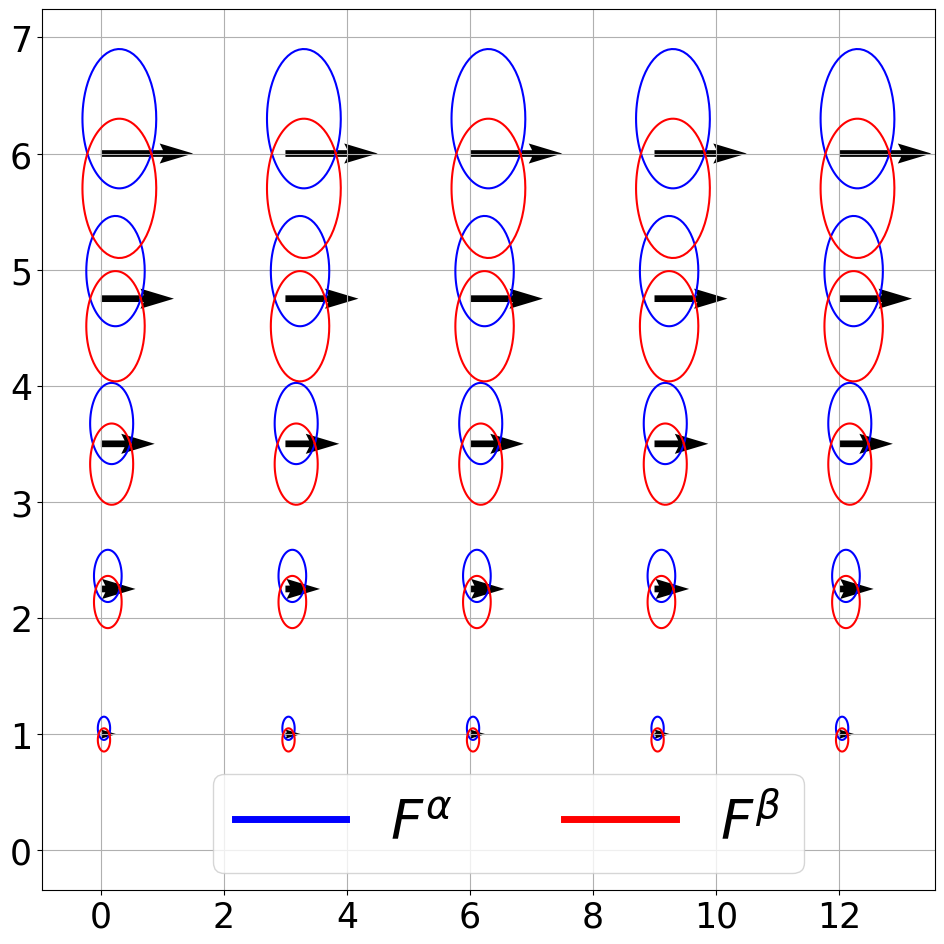

In [225]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

for i1, i2,x1,x2 in zip(indicatrix_alpha, indicatrix_beta, X1, X2):
    for b1, b2, y1, y2 in zip(i1, i2, x1, x2):
        ax.plot(b1[:,0], b1[:,1], color='blue')
        ax.plot(b2[:,0], b2[:,1], color='red')
        ax.quiver(y1, y2, y2, 0.0, scale_units='x', scale=4.0, color='black')

ax.grid(True)

ax.plot([0],[0], color="blue", label=r'$F^{\alpha}$', linewidth=5.0)
ax.plot([0],[0], color="red", label=r'$F^{\beta}$', linewidth=5.0)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.225,0.075), ncol=2, fontsize=40)
    
fig.tight_layout()

save_path = f'{figure_path}{model_name}_indicatrix.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

fig.tight_layout()

plt.show()

In [230]:
xscales = [-1.0, 35.0]
yscales = [-1.0, 10.0]

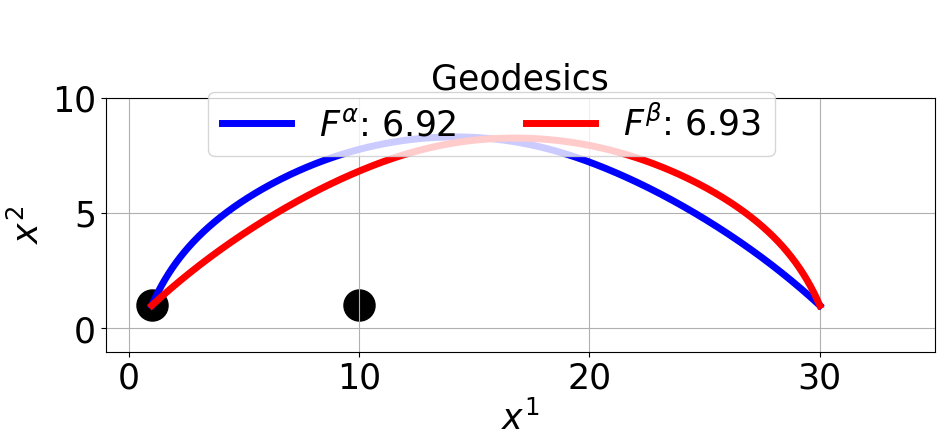

In [231]:
N_tacks = len(curves.keys())//2-1

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

ts1 = curves['Geodesic']['travel_time']
ts2 = curves['ReverseGeodesic']['travel_time']

#Curves with no tacking
ax.plot(curves['Geodesic']['zs'][:,0], curves['Geodesic']['zs'][:,1], color='blue', linewidth=5.0, alpha=1.0)
ax.plot(curves['ReverseGeodesic']['zs'][:,0], curves['ReverseGeodesic']['zs'][:,1], color='red', linewidth=5.0, alpha=1.0)

ax.set_xlabel(r'$x^{1}$', fontsize=25)
ax.set_ylabel(r'$x^{2}$', fontsize=25)
ax.set_title(f"Geodesics", fontsize=25)
ax.grid(True)
ax.set_xlim(xscales[0], xscales[1])
ax.set_ylim(yscales[0], yscales[1])
ax.set_aspect('equal', adjustable='box')

#Start and end point
ax.scatter(z0[0], z0[1], color="black", s=500)
ax.scatter(zT[0], zT[1], color="black", s=500)

ax.plot([0],[0], color="blue", label=rf'$F^{{\alpha}}$: {ts1:.2f}', linewidth=5.0)
ax.plot([0],[0], color="red", label=rf'$F^{{\beta}}$: {ts2:.2f}', linewidth=5.0)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.22,0.65), ncol=2, fontsize=25)
    
fig.tight_layout()

save_path = f'{figure_path}{model_name}_geodesic.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')
    
plt.show()


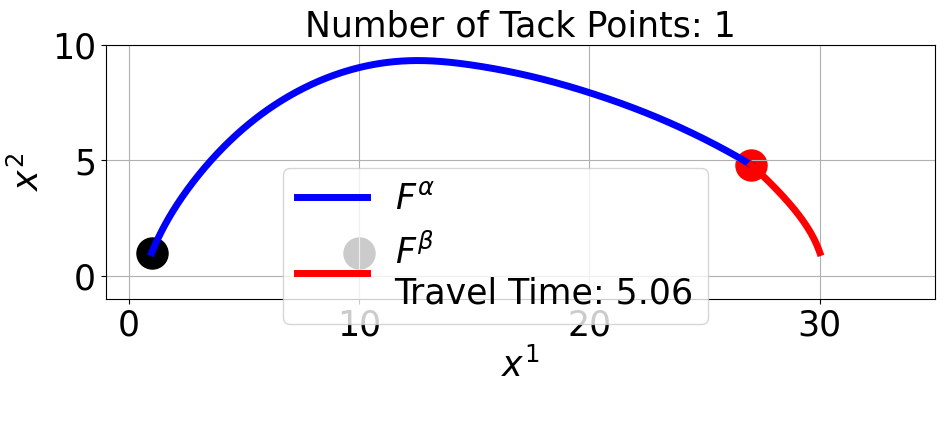

In [233]:
N_tacks = len(curves.keys())//2-1

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

ts1 = curves[f'Tacking_1']['travel_time']
ts2 = curves[f'ReverseTacking_1']['travel_time']

#Curves with no tacking
ax.plot(curves[f'Tacking_1']['zs'][:T,0], curves[f'Tacking_1']['zs'][:T,1], color='blue', linewidth=5.0, alpha=1.0)
ax.plot(curves[f'Tacking_1']['zs'][T:,0], curves[f'Tacking_1']['zs'][T:,1], color='red', linewidth=5.0, alpha=1.0)
ax.scatter(curves[f'Tacking_1']['zs'][T,0], curves[f'Tacking_1']['zs'][T,1], color='red', s=500)

ax.set_xlabel(r'$x^{1}$', fontsize=25)
ax.set_ylabel(r'$x^{2}$', fontsize=25)
ax.set_title(f"Number of Tack Points: 1", fontsize=25)
ax.grid(True)
ax.set_xlim(xscales[0], xscales[1])
ax.set_ylim(yscales[0], yscales[1])
ax.set_aspect('equal', adjustable='box')

#Start and end point
ax.scatter(z0[0], z0[1], color="black", s=500)
ax.scatter(zT[0], zT[1], color="black", s=500)

ax.plot([0],[0], color="blue", label=rf'$F^{{\alpha}}$', linewidth=5.0)
ax.plot([0],[0], color="red", label=rf'$F^{{\beta}}$' + "\n" + f"Travel Time: {ts1:.2f}", linewidth=5.0)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.30,0.25), ncol=1, fontsize=25)
    
fig.tight_layout()

save_path = f'{figure_path}{model_name}_tack1.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')
    
plt.show()


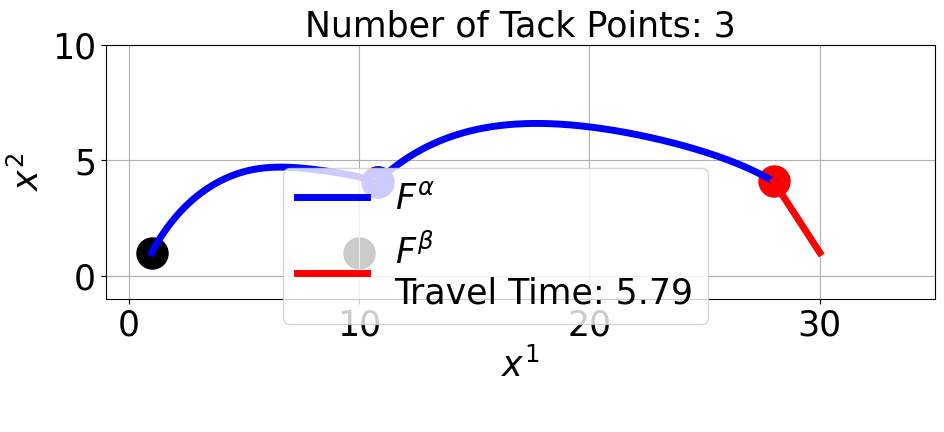

In [234]:
N_tacks = len(curves.keys())//2-1

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

ts1 = curves[f'Tacking_3']['travel_time']
ts2 = curves[f'ReverseTacking_3']['travel_time']

#Curves with no tacking
ax.plot(curves[f'Tacking_3']['zs'][:T,0], curves[f'Tacking_3']['zs'][:T,1], color='blue', linewidth=5.0, alpha=1.0)
ax.plot(curves[f'Tacking_3']['zs'][T:(2*T),0], curves[f'Tacking_3']['zs'][T:(2*T),1], color='red', linewidth=5.0, alpha=1.0)
ax.plot(curves[f'Tacking_3']['zs'][(2*T):(3*T),0], curves[f'Tacking_3']['zs'][(2*T):(3*T),1], color='blue', linewidth=5.0, alpha=1.0)
ax.plot(curves[f'Tacking_3']['zs'][(3*T):,0], curves[f'Tacking_3']['zs'][(3*T):,1], color='red', linewidth=5.0, alpha=1.0)

ax.scatter(curves[f'Tacking_3']['zs'][T,0], curves[f'Tacking_3']['zs'][T,1], color='red', s=500)
ax.scatter(curves[f'Tacking_3']['zs'][2*T,0], curves[f'Tacking_3']['zs'][2*T,1], color='blue', s=500)
ax.scatter(curves[f'Tacking_3']['zs'][3*T,0], curves[f'Tacking_3']['zs'][3*T,1], color='red', s=500)

ax.set_xlabel(r'$x^{1}$', fontsize=25)
ax.set_ylabel(r'$x^{2}$', fontsize=25)
ax.set_title(f"Number of Tack Points: 3", fontsize=25)
ax.grid(True)
ax.set_xlim(xscales[0], xscales[1])
ax.set_ylim(yscales[0], yscales[1])
ax.set_aspect('equal', adjustable='box')

#Start and end point
ax.scatter(z0[0], z0[1], color="black", s=500)
ax.scatter(zT[0], zT[1], color="black", s=500)

ax.plot([0],[0], color="blue", label=rf'$F^{{\alpha}}$', linewidth=5.0)
ax.plot([0],[0], color="red", label=rf'$F^{{\beta}}$' + "\n" + f"Travel Time: {ts1:.2f}", linewidth=5.0)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.30,0.25), ncol=1, fontsize=25)
    
fig.tight_layout()

save_path = f'{figure_path}{model_name}_tack3.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')
    
plt.show()


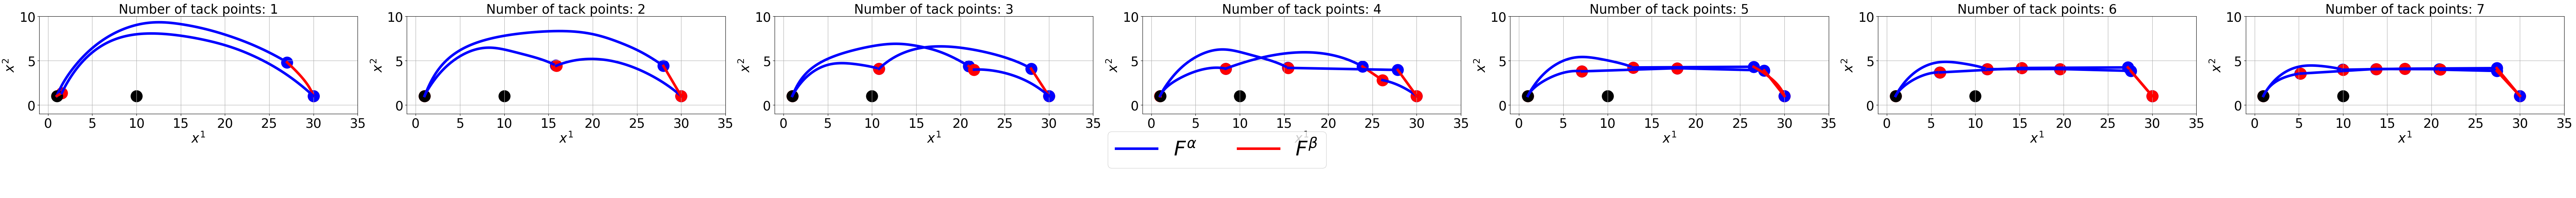

In [235]:
N_tacks = len(curves.keys())//2-1

fig = plt.figure(figsize=((N_tacks)*10,10))

for i in range(1, N_tacks+1):
    ax = fig.add_subplot(1,N_tacks,i)

    tack_curve = curves[f'Tacking_{i}']['zs']
    reverse_tack_curve = curves[f'ReverseTacking_{i}']['zs']
    
    #Plotting curves
    for j in range(i+1):
        if j % 2 == 0:
            #Plotting Curves
            ax.plot(tack_curve[(T*j):(T*(j+1))][:,0], 
                    tack_curve[(T*j):(T*(j+1))][:,1], 
                    color="blue",
                    linewidth=5.0)
            ax.plot(reverse_tack_curve[(T*j):(T*(j+1))][:,0], 
                    reverse_tack_curve[(T*j):(T*(j+1))][:,1], 
                    color="red",
                    linewidth=5.0)
            
            #Plotting points
            ax.scatter(tack_curve[(T*(j+1))][0], 
                       tack_curve[(T*(j+1))][1],
                       color="blue",
                       s=500)
            ax.scatter(reverse_tack_curve[(T*(j+1))][0], 
                       reverse_tack_curve[(T*(j+1))][1],
                       color="red",
                       s=500)
        else:
            #Plotting Curves
            ax.plot(tack_curve[(T*j):(T*(j+1))][:,0], 
                    tack_curve[(T*j):(T*(j+1))][:,1], 
                    color="red",
                    linewidth=5.0)
            ax.plot(reverse_tack_curve[(T*j):(T*(j+1))][:,0], 
                    reverse_tack_curve[(T*j):(T*(j+1))][:,1], 
                    color="blue",
                    linewidth=5.0)
            
            #Plotting points
            ax.scatter(tack_curve[(T*(j+1))][0], 
                       tack_curve[(T*(j+1))][1],
                       color="red",
                       s=500)
            ax.scatter(reverse_tack_curve[(T*(j+1))][0], 
                       reverse_tack_curve[(T*(j+1))][1],
                       color="blue",
                       s=500)

    ax.set_xlabel(r'$x^{1}$', fontsize=25)
    ax.set_ylabel(r'$x^{2}$', fontsize=25)
    ax.set_title(f"Number of tack points: {i}", fontsize=25)
    ax.grid(True)
    ax.set_xlim(xscales[0], xscales[1])
    ax.set_ylim(yscales[0], yscales[1])
    ax.set_aspect('equal', adjustable='box')
    
    #Start and end point
    ax.scatter(z0[0], z0[1], color="black", s=500)
    ax.scatter(zT[0], zT[1], color="black", s=500)

ax.plot([0],[0], color="blue", label=r'$F^{\alpha}$', linewidth=5.0)
ax.plot([0],[0], color="red", label=r'$F^{\beta}$', linewidth=5.0)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.43,0.15), ncol=2, fontsize=40)
    
fig.tight_layout()

save_path = f'{figure_path}{model_name}.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')
    
plt.show()
